In [1]:
from pathlib import Path

THIS = Path(".")
BASE = THIS / ".."
BASE = BASE.absolute().resolve()

MODEL = BASE / "model"
EXPORTS = BASE / "exports"

MODEL_NAME="Llama-2-7b-hf"



MODEL_PATH = MODEL / MODEL_NAME
EXPORTS = EXPORTS / MODEL_NAME

## Engine

### Llamacpp

In [2]:
METHOD = "engine/llamacpp"
METHOD_EXPORTS = EXPORTS / METHOD

In [3]:
# print paths
print("BASE:", BASE)
print("MODEL:", MODEL)
print("MODEL_PATH:", MODEL_PATH)
print("METHOD_EXPORTS:", METHOD_EXPORTS)


BASE: /home/shwu/LLM-Efficiency-Survey
MODEL: /home/shwu/LLM-Efficiency-Survey/model
MODEL_PATH: /home/shwu/LLM-Efficiency-Survey/model/Llama-2-7b-hf
METHOD_EXPORTS: /home/shwu/LLM-Efficiency-Survey/exports/Llama-2-7b-hf/engine/llamacpp


In [4]:
# gguf quant sizes
gguf_models = [x for x in METHOD_EXPORTS.iterdir() if x.is_file() and x.suffix == ".gguf"]
gguf_models.append(MODEL_PATH)

for model in gguf_models:

    # model_size := size of .gguf files
    if model.suffix == ".gguf":
        model_size = model.stat().st_size
    else:
        model_size = sum([x.stat().st_size for x in model.glob("*.safetensors")])
    print(f"{model.name}: {model_size / (1024 ** 3):.2f} GiB")

ggml-model-awq_q4_0.gguf: 3.56 GiB
ggml-model-q4_k_m.gguf: 3.80 GiB
ggml-model-q2_k.gguf: 2.36 GiB
ggml-model-q8_0.gguf: 6.67 GiB
ggml-model-q4_k_s.gguf: 3.59 GiB
ggml-model-f16.gguf: 12.55 GiB
ggml-model-q4_0.gguf: 3.56 GiB
ggml-model-f32.gguf: 25.10 GiB
Llama-2-7b-hf: 12.55 GiB


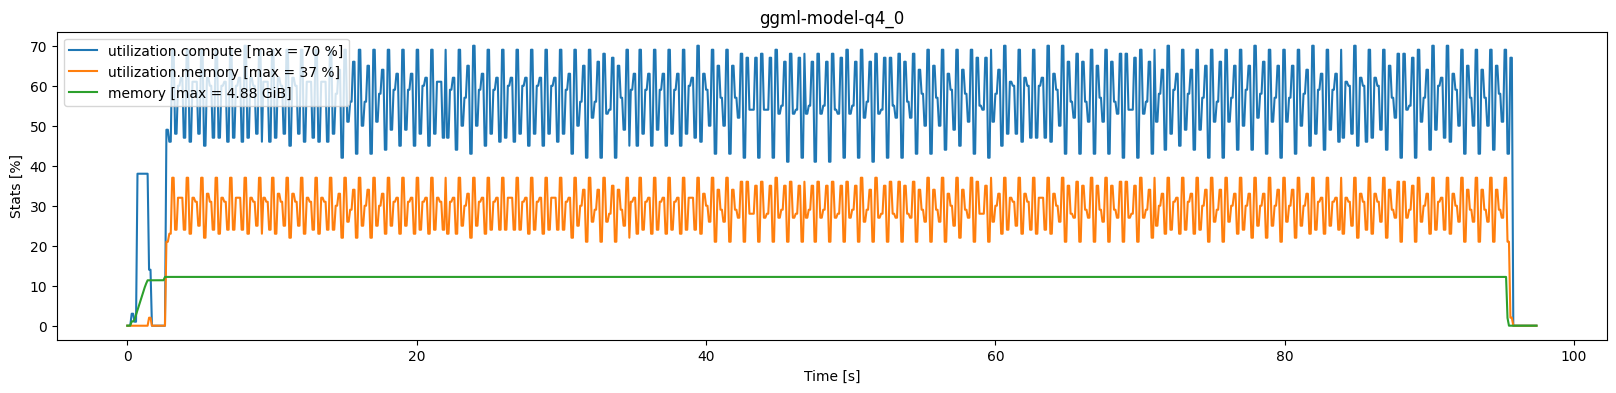

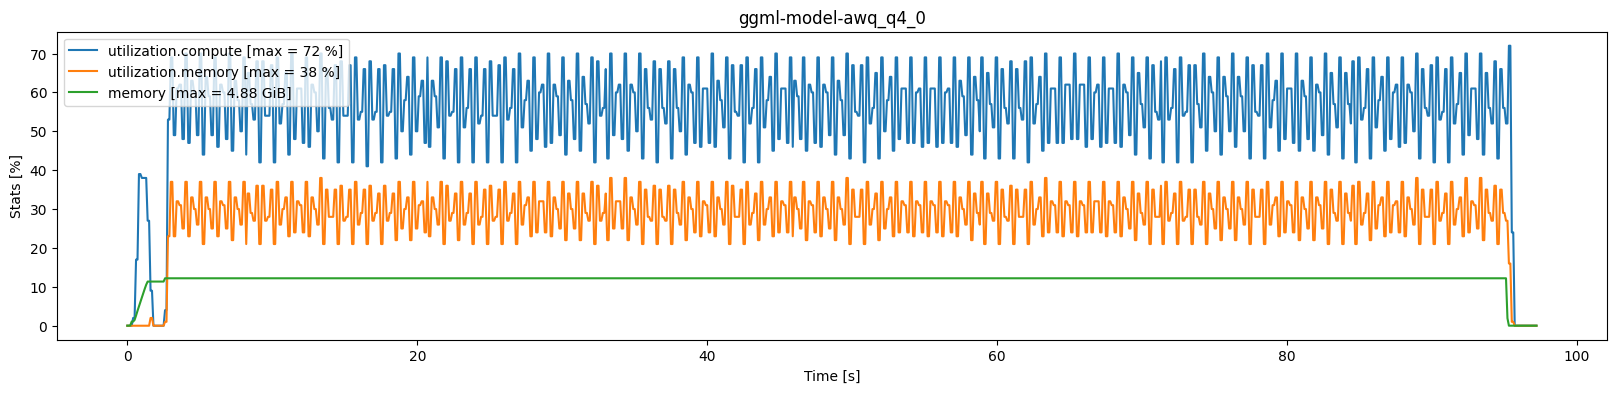

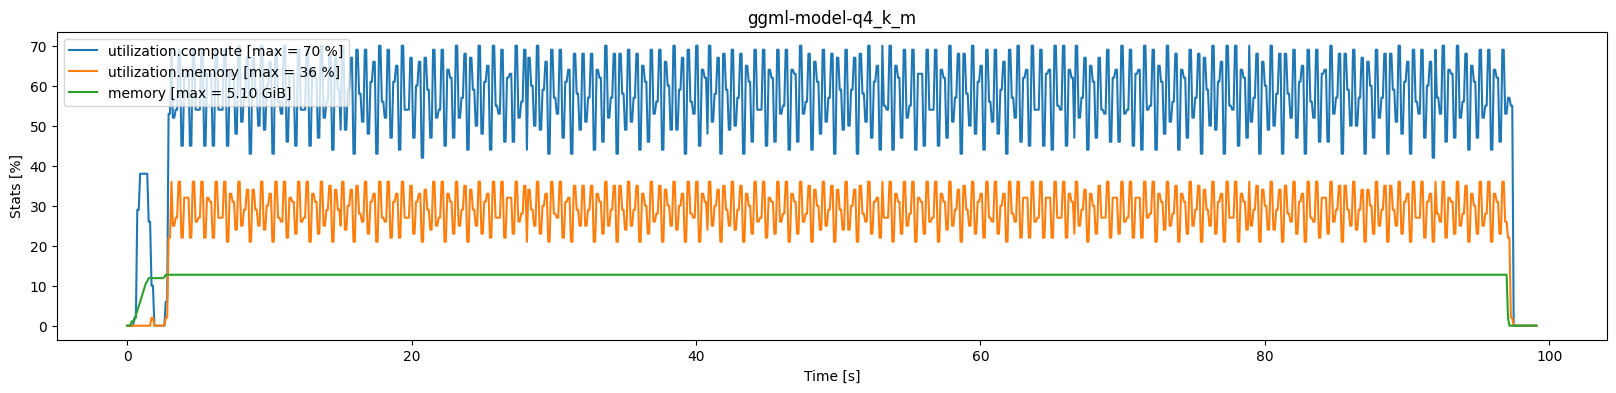

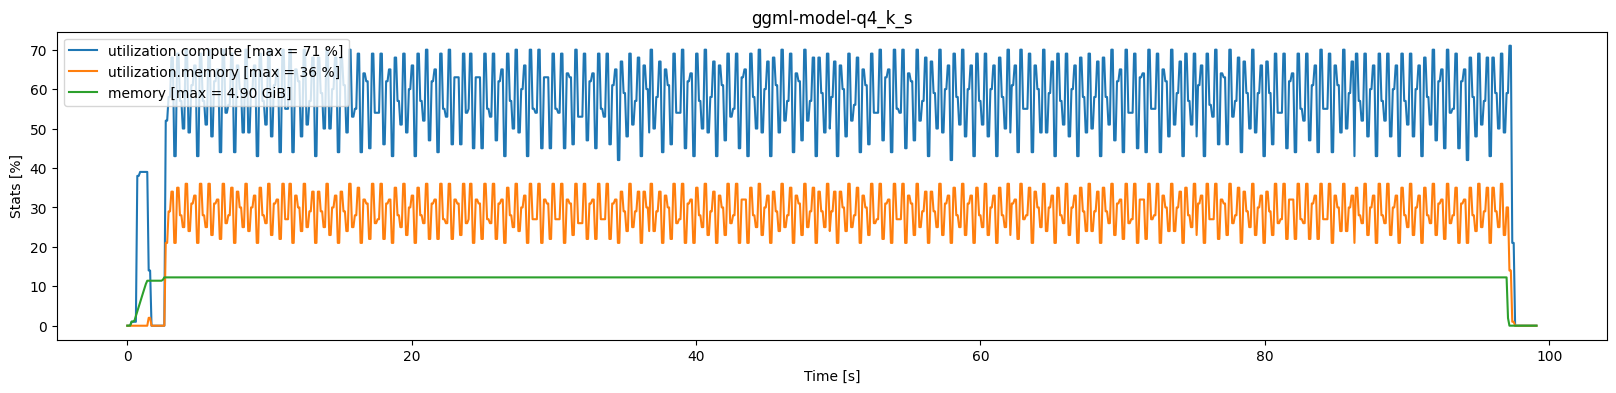

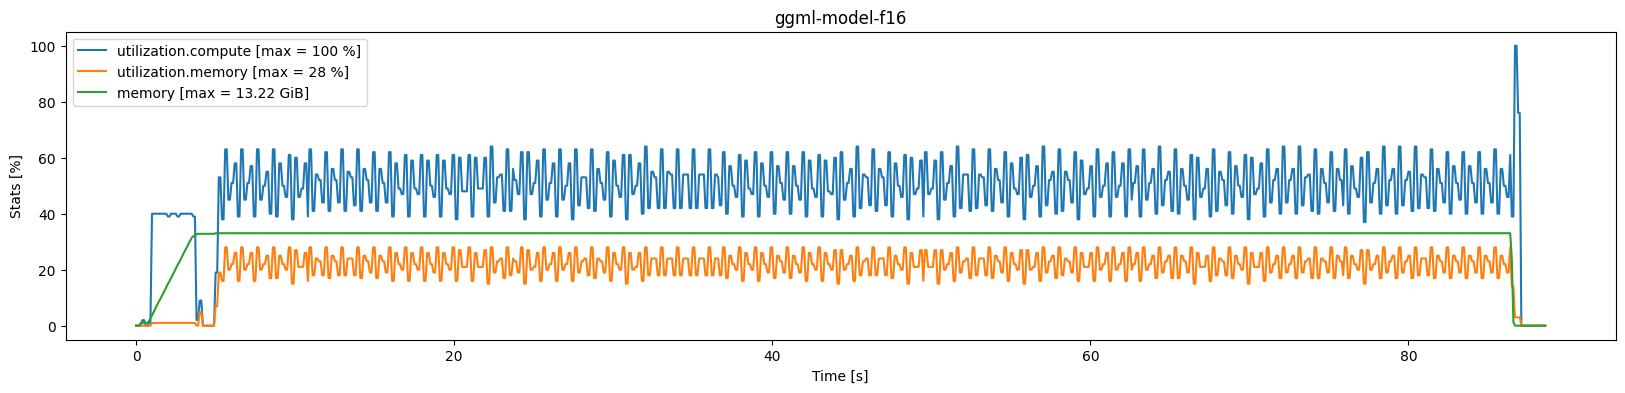

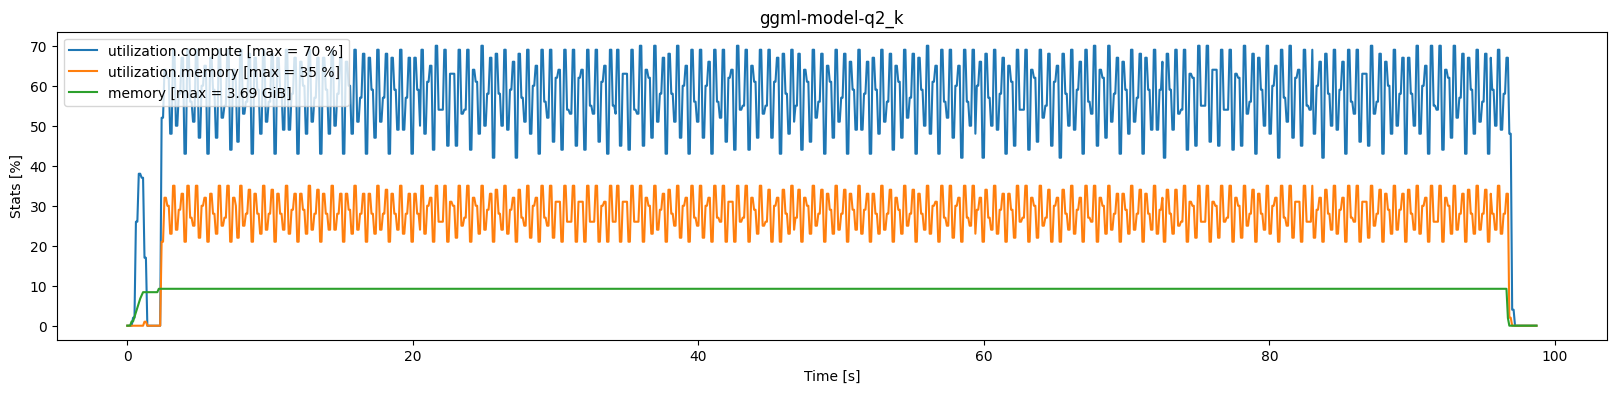

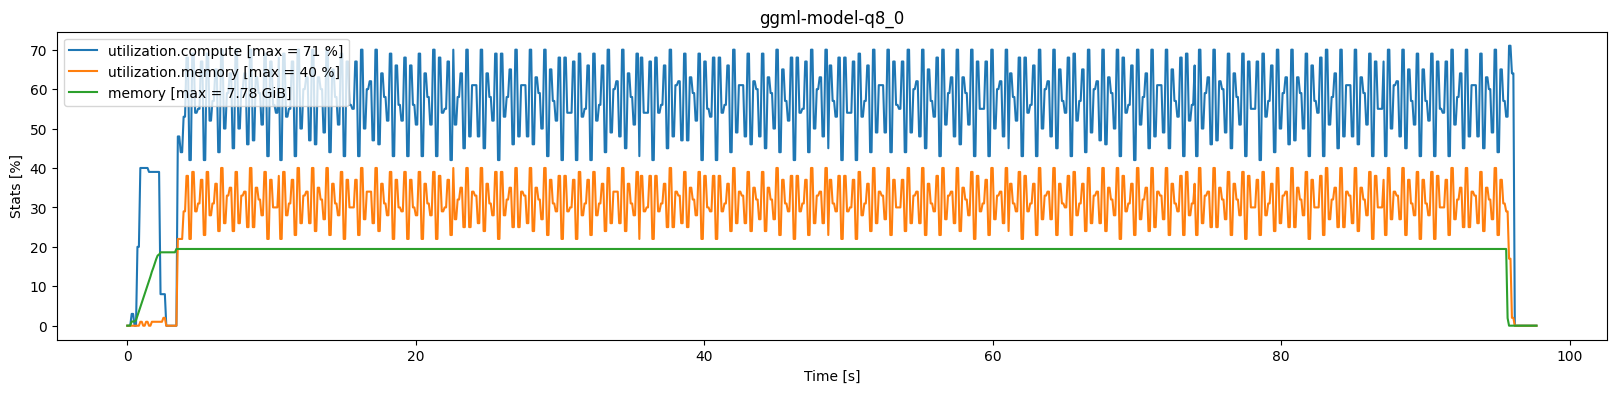

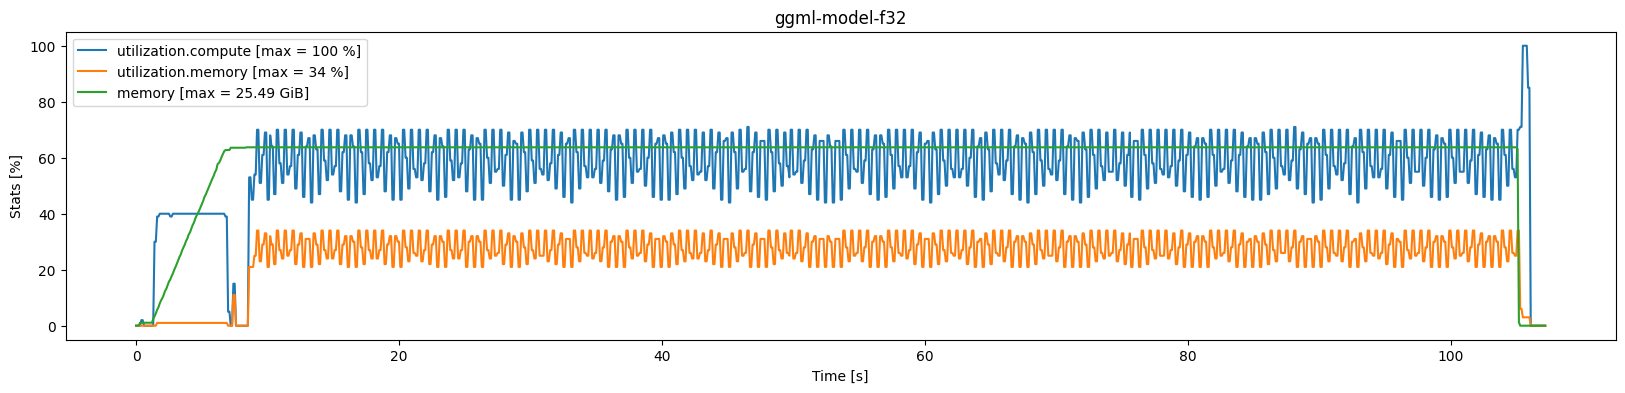

In [5]:
# max mem usage
import pandas as pd
import matplotlib.pyplot as plt
all_csvs = list(METHOD_EXPORTS.glob("*.csv"))

# csv header
# utilization.gpu [%], utilization.memory [%], memory.used [MiB], memory.free [MiB], memory.total [MiB]
utlization_gpu_key = "utilization.gpu [%]"
utilization_memory_key = " " + "utilization.memory [%]"
memory_used_key = " " + "memory.used [MiB]"
memory_free_key = " " + "memory.free [MiB]"
memory_total_key = " " + "memory.total [MiB]"

for csv in all_csvs:
    if not "bench" in csv.name:
        continue
    df = pd.read_csv(csv)

    # plot csv of utilization.memory [%] and utilization.gpu [%] both on y-axis
    fig, ax1 = plt.subplots(figsize=(20, 4))
    plt.title(csv.name.split('usage')[-1][1:-4])
    ax1.set_ylabel("Stats [%]")
    ax1.set_xlabel("Time [s]")
    ax1.plot(df.index * 0.1, df[utlization_gpu_key], label=f"utilization.compute [max = {df[utlization_gpu_key].max()} %]")
    ax1.plot(df.index * 0.1, df[utilization_memory_key], label=f"utilization.memory [max = {df[utilization_memory_key].max()} %]")
    ax1.plot(df.index * 0.1, (df[memory_used_key] / df[memory_total_key]) * 100, label=f"memory [max = {df[memory_used_key].max() / 1024:.2f} GiB]")
    ax1.legend(loc="upper left")

    # set title
    

In [6]:
# benchmark logs
all_logs = list(METHOD_EXPORTS.glob("*.log"))

data = {}

for log in all_logs:
    log_key = f"{log.name.split('ggml')[-1][1:-4]}"
    data[log_key] = data.get(log_key, {})
    if not "bench" in log.name:
        continue
    if not "ppl" in log.name:
        with open(log) as f:
            lines = f.readlines()
            for line in lines:
                if "tg 128" in line:
                    data[log_key]["tps"] = line.split("|")[-2].strip()
    else:
        with open(log) as f:
            lines = f.readlines()
            for line in lines:
                if "Final estimate" in line:
                    data[log_key]["ppl"] = line.split("=")[-1].strip()

In [7]:
import numpy as np
import pandas as pd
df = pd.DataFrame([(k.replace("_", " ").replace("-", " "), v['tps'], v['ppl']) for (k,v) in sorted(data.items())], columns=['method', 'tps', 'ppl'])
df


,method,tps,ppl
0,model awq q4 0,129.25 ± 0.09,5.9143 +/- 0.03315
1,model f16,66.81 ± 0.04,5.7986 +/- 0.03237
2,model f32,42.21 ± 0.05,5.8160 +/- 0.03249
3,model q2 k,102.15 ± 0.20,6.9685 +/- 0.03974
4,model q4 0,128.97 ± 0.36,5.9647 +/- 0.03350
5,model q4 k m,104.09 ± 0.11,5.8804 +/- 0.03280
6,model q4 k s,109.72 ± 0.11,5.8791 +/- 0.03277
7,model q8 0,93.39 ± 0.05,5.7996 +/- 0.03237


In [47]:
each_line = "{method} & {hardware_support} & GGUF {compression_type} & {wm} & {rm} & {token_per_sec} & {ppl} \\\\"

for k,v in data.items():
    print(each_line.format(
        method="",
        hardware_support="Yes" if "hf" in k else "No",
        compression_type=k.replace("_", " ").replace("-", " "),
        wm="Yes" if "wm" in k else "No",
        rm="Yes" if "rm" in k else "No",
        token_per_sec=v['tps'].split("±")[0].strip(),
        ppl=v['ppl'].split("+/-")[0].strip()
    ))

 & No & GGUF model q4 0 & No & No & 128.97 & 5.9647 \\
 & No & GGUF model q2 k & No & No & 102.15 & 6.9685 \\
 & No & GGUF model q8 0 & No & No & 93.39 & 5.7996 \\
 & No & GGUF model f16 & No & No & 66.81 & 5.7986 \\
 & No & GGUF model q4 k s & No & No & 109.72 & 5.8791 \\
 & No & GGUF model awq q4 0 & No & No & 129.25 & 5.9143 \\
 & No & GGUF model q4 k m & No & No & 104.09 & 5.8804 \\
 & No & GGUF model f32 & No & No & 42.21 & 5.8160 \\


In [ ]:
Apple Silicon, AMD GPU
AV, AVX2, AVX512 (x86)